#Подключаем библиотеки


In [ ]:
from __future__ import print_function #как я понял это нужно, чтобы использовать разные функции последних версий питона в более ранних
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from PIL import Image
import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models


import copy

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(device)

cuda


#Подгрузим картинки
# (Я их пока просто подгрузил в колаб напрямую)




In [ ]:
image_size = 512 if cuda else 128

In [ ]:
loader = transforms.Compose([
                             transforms.Resize(image_size),
                             transforms.ToTensor()
])
def image_loader(image_path):
      image = Image.open(image_path)
      image = loader(image).unsqueeze(0)
      return image.to(device, torch.float)
style_image = image_loader("/content/picasso.jpg")
content_image = image_loader("/content/city (1).jpg")
white_noise = image_loader("/content/write (1).jpg")
assert style_image.size() == content_image.size()

#Нарисуем  картинки

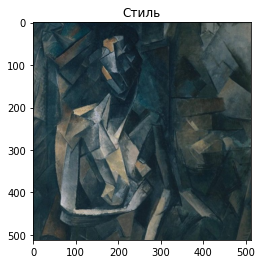

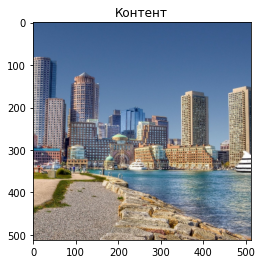

In [ ]:
unloader = transforms.ToPILImage()
plt.ion()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(1e-3)

  
plt.figure()
imshow(style_image, title='Стиль')


plt.figure()
imshow(content_image, title='Контент')


#Реализуем лоссы для нашей модели 

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
      self.loss = F.mse_loss(input, self.target)
      return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a*b, c*d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
      super(StyleLoss, self).__init__()
      self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

#Импортируем модель

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization,self).__init__()
        self.mean = torch.tensor(mean).view(-1,1,1 )
        self.std = torch.tensor(std).view(-1,1,1 )
    def forward(self, image):
      return (image - self.mean)/self.std

In [ ]:
content_layers_default = ['conv_2', 'conv_4']
style_layers_default = ['conv_1', 'conv_3','conv_5']

def get_style_model_and_losses(cnn, 
                               normalization_mean, 
                               normalization_std,
                               style_image,
                               content_image,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default
                               ):
      normalization = Normalization(normalization_mean, normalization_std).to(device)

      content_losses = []
      style_losses = []
      model = nn.Sequential(normalization)
      i = 0
      for layer in cnn.children():
          if isinstance(layer, nn.Conv2d):
              i += 1
              name = 'conv_{}'.format(i)
          elif isinstance(layer,nn.ReLU):
              name = 'relu_{}'.format(i)
              layer = nn.ReLU(inplace=False)
          elif isinstance(layer, nn.MaxPool2d):
              name = 'pool_{}'.format(i)
          elif isinstance(layer, nn.BatchNorm2d):
              name = 'bn_{}'.format(i)
          else:
              raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
          model.add_module(name, layer)

          if name in content_layers:
              target = model(content_image).detach()
              content_loss =ContentLoss(target)
              model.add_module("content_loss_{}".format(i), content_loss)
              content_losses.append(content_loss)


          if name in style_layers:
             target_feature = model(style_image).detach()
             style_loss = StyleLoss(target_feature)
             model.add_module("style_loss_{}".format(i), style_loss)
             style_losses.append(style_loss)
      for i in range(len(model)-1, -1, -1):
          if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
              break


      model = model[:(i+1)]


      return model, style_losses, content_losses


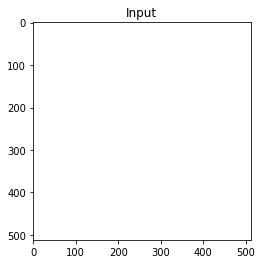

In [ ]:
input_image = white_noise.clone()
plt.figure()
imshow(input_image, title='Input')

#Градиентный спуск

In [ ]:
def get_input_optimizer(input_image):
    optimizer = optim.LBFGS([input_image])
    return optimizer

In [ ]:
def run_style_transfer(cnn,
                       normalization_mean,
                       normalization_std,
                       content_image,
                       style_image,
                       input_image,
                       num_steps=500,
                       style_weight=1000000,
                       content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_image, content_image)


    input_image.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_image)


    run = [0]
    while run[0] <= num_steps:


        def closure():


            with torch.no_grad():
                  input_image.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_image)
            style_score = 0
            content_score = 0


            for sl in style_losses:
               style_score += sl.loss
            for cl in content_losses:
               content_score += cl.loss


            style_score *= style_weight
            content_score *= content_weight


            loss = style_score + content_score
            loss.backward()


            run[0] +=1
            if run[0]%50 == 0:
                print("run{}",format(run))
                print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
                print()


            return style_score + content_score


        optimizer.step(closure)
    with torch.no_grad():
        input_image.clamp_(0, 1)

    return input_image


  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


run{} [50]
Style Loss: 310.828369 Content Loss: 43.132339

run{} [100]
Style Loss: 26.635731 Content Loss: 41.167496

run{} [150]
Style Loss: 5.678542 Content Loss: 32.195869

run{} [200]
Style Loss: 2.582221 Content Loss: 27.008915

run{} [250]
Style Loss: 1.808562 Content Loss: 24.376345

run{} [300]
Style Loss: 1.501865 Content Loss: 22.824501

run{} [350]
Style Loss: 1.408813 Content Loss: 21.725346

run{} [400]
Style Loss: 1.380912 Content Loss: 20.951633

run{} [450]
Style Loss: 1.328691 Content Loss: 20.491470

run{} [500]
Style Loss: 1.241575 Content Loss: 20.210566

run{} [50]
Style Loss: 37.848980 Content Loss: 26.798061

run{} [100]
Style Loss: 24.165550 Content Loss: 24.837872

run{} [150]
Style Loss: 12.994398 Content Loss: 24.198328

run{} [200]
Style Loss: 5.074128 Content Loss: 23.616594

run{} [250]
Style Loss: 1.928541 Content Loss: 22.215845

run{} [300]
Style Loss: 1.293986 Content Loss: 21.030357

run{} [350]
Style Loss: 1.060570 Content Loss: 20.342817

run{} [400

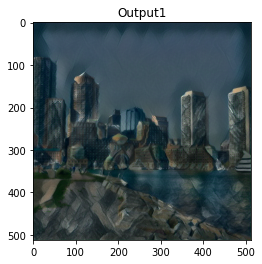

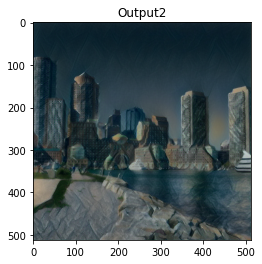

In [ ]:
output1 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_image, style_image, white_noise.clone())
output2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_image, style_image, content_image.clone())

plt.figure()
imshow(output1, title='Output1')


plt.figure()
imshow(output2, title='Output2')


plt.ioff()
plt.show()